In [95]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma
from scipy.integrate import trapz, simpson
import scipy.interpolate as scint
import pandas as pd
import os
from importlib import reload
from sklearn.ensemble import GradientBoostingClassifier as BDT_classifier
from sklearn.ensemble import AdaBoostClassifier as AB_classifier
from sklearn.metrics import confusion_matrix

plt.style.use("../KD_style.mplstyle")

In [96]:
signal_test = pd.read_csv("./BDT_signal_test.txt", sep = " ", names = ["x", "y", "z"])
signal_train = pd.read_csv("./BDT_signal_train.txt", sep = " ", names = ["x", "y", "z"])
background_test = pd.read_csv("./BDT_background_test.txt", sep = " ", names = ["x", "y", "z"])
background_train = pd.read_csv("./BDT_background_train.txt", sep = " ", names = ["x", "y", "z"])
print(signal_train.shape, background_train.shape)
print(signal_test.shape, background_test.shape)

(4000, 3) (4000, 3)
(2000, 3) (2000, 3)


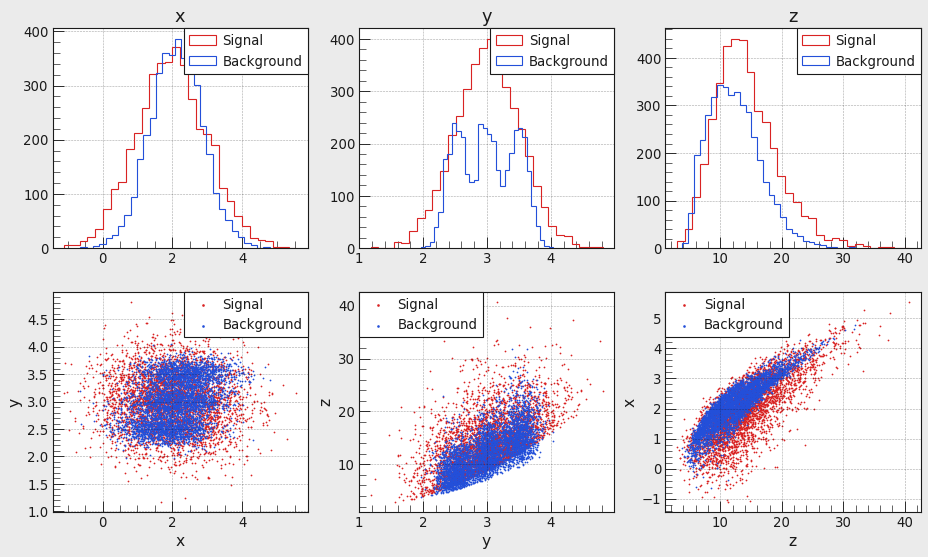

In [117]:
def plot_hist(data, variable, ax, bins = 30):
    ax.hist(data[variable].values, bins = bins, alpha = 1, label = variable, histtype = "step")
    
def plot_scatter(data, variables, ax):
    var1, var2 = variables
    sns.scatterplot(data = data, x = var1, y = var2, ax = ax, linewidth = 0, label = "var1", s = 10)

histboolean = [[True, True, True],
               [False, False, False]]

variableplotted = [["x", "y", "z"],
                   [["x", "y"], ["y", "z"], ["z", "x"]]]

fig, axes = plt.subplots(2,3, figsize = (14, 8))
for row, truthrow, variablerow in zip(axes, histboolean, variableplotted):
    for ax, hist, variable in zip(row, truthrow, variablerow):
        if hist:
            plot_hist(signal_train, variable, ax)
            plot_hist(background_train, variable, ax)
            ax.set_title(variable)
            h, _ = ax.get_legend_handles_labels()
            ax.legend(h, ["Signal", "Background"])
        else:
            plot_scatter(signal_train, variable, ax)
            plot_scatter(background_train, variable, ax)
            h, _ = ax.get_legend_handles_labels()
            ax.legend(h, ["Signal", "Background"])
        

In [98]:
train = pd.concat([signal_train, background_train], ignore_index= True)
sb_bool_train = [1 for i in signal_train.index] + [0 for i in background_train.index]
test = pd.concat([signal_test, background_test], ignore_index= True)
sb_bool_test = [1 for i in signal_test.index] + [0 for i in background_test.index]
bdt = AB_classifier()
bdt.fit(train, sb_bool_train)
# z = bdt.staged_score(train, sb_bool)
print(bdt.score(train, sb_bool_train))
prediction = bdt.predict(test)
correct = np.sum(~np.logical_xor(sb_bool_test, prediction))
print(correct/len(test.index))

0.909125
0.8905


1.0
0.99475
[[9.900e-01 1.000e-02]
 [5.000e-04 9.995e-01]]
[[0.9905 0.0095]
 [0.0065 0.9935]]


TypeError: unsupported operand type(s) for /: 'list' and 'int'

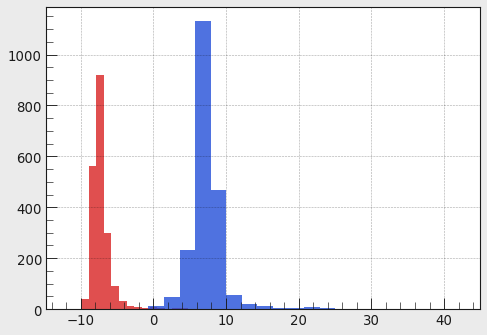

In [115]:
bdt = BDT_classifier(n_estimators=2000)
hmm = bdt.fit(train, sb_bool_train)
# z = bdt.staged_score(train, sb_bool)
print(bdt.score(train, sb_bool_train))
prediction = bdt.predict(test)
correct = np.sum(~np.logical_xor(sb_bool_test, prediction))
print(correct/len(test.index))

confusion = confusion_matrix(sb_bool_test, prediction)
print(confusion/2000)

dec1 = bdt.decision_function(background_test)
dec2 = bdt.decision_function(signal_test)
plt.hist(dec1, bins = 20, alpha = 0.8)
plt.hist(dec2, bins= 20, alpha = 0.8)
cut = 2
testsum = [1 if i < cut else 0 for i in dec1] + [0 if i > cut else 1 for i in dec2]
confusion2 = confusion_matrix(sb_bool_test, testsum)
print(confusion2/2000)

print(testsum/4000)